# Some Linalg Exercises in Numpy
- Matrix Multiplication
- Eigendecomposition and Reconstruction
- PCA
- Euclidean Distance
- Linear Regression

In [1]:
import numpy as np

# Matrix Multiplication
- Implement Matrix multiplication

In [5]:
A = np.random.randint(low=0, high=9, size=(3, 4))
B = np.random.randint(low=0, high=9, size=(4, 3))

In [10]:
def mydot(A, B):
    res = np.zeros(shape=(A.shape[0], B.shape[1]))
    for i, row in enumerate(A):
        for j, col in enumerate(B.T):
            res[i, j] = (row * col).sum()
    return res

In [15]:
(mydot(A, B) == np.dot(A, B)).all()

np.True_

# Eigendecomposition and Reconstruction
- Use np eig to decompose a matrix and then reconstruct it using only top eigenvectors
- $ A = PDP^{-1}$
- D is $\lambda I$, where $\lambda$ are the eigenvalues from the decomposition
- P is $[v1, v2, .., vn]$ are the eigenvectors of decomposition
- Note: if A is symmetric, then eigenvectors are orthonormal -> $P^{T}*P=I$ -> $P^T=P^{-1}$

In [66]:
A = np.random.randn(100, 5)
A = np.dot(A.T, A) # need a symmetric matrix to get real and orthogonal eigens

with np.printoptions(precision=2, suppress=True):
    print(A)

[[119.44  -5.58   3.93   8.   -16.73]
 [ -5.58 127.95   1.3  -24.75 -14.75]
 [  3.93   1.3   97.54   3.75   0.22]
 [  8.   -24.75   3.75  87.77   9.36]
 [-16.73 -14.75   0.22   9.36 115.66]]


In [90]:
eigenval, eigenvec = np.linalg.eig(A) 
eigenvec = eigenvec.T # np returns column vectors
print(len(eigenval), "eigenvalues")
print(len(eigenvec), "eigenvectors of size", eigenvec[0].shape)

5 eigenvalues
5 eigenvectors of size (5,)


In [91]:
print(eigenval) # increasing

[ 74.36577106  92.45760986  99.39868986 133.30642349 148.8324261 ]


In [92]:
with np.printoptions(precision=2, suppress=True):
    print("Reconstruction using all eigenvectors")
    print(eigenvec.T @ np.diag(eigenval) @ eigenvec)

Reconstruction using all eigenvectors
[[119.44  -5.58   3.93   8.   -16.73]
 [ -5.58 127.95   1.3  -24.75 -14.75]
 [  3.93   1.3   97.54   3.75   0.22]
 [  8.   -24.75   3.75  87.77   9.36]
 [-16.73 -14.75   0.22   9.36 115.66]]


In [106]:
errors = []
for k in range(5):
    A_rec = eigenvec[k:].T @ np.diag(eigenval[k:]) @ eigenvec[k:]
    errors.append(float(np.linalg.norm(A - A_rec, ord=2)))
print("Reconstruction fro errors for smaller number of eigenvectors")
print(errors)

Reconstruction fro errors for smaller number of eigenvectors
[2.9396722207651104e-13, 74.36577106426088, 92.45760985859076, 99.39868985716811, 133.3064234946695]


# PCA
- Eigendecomposition on Covariance Matrix (don't forget 1/(n-1) )
- sklearn PCA centeres data, need to do that to get same results
- np.eig doens't guarantee an order for the eigenvalues -> need to sort
- np.eig eigenvectors might have mixed signs -> need to flip some

In [236]:
A = np.random.randn(100, 5) 
A = A - A.mean(axis=0) # centering, sklearn PCA does this under the hood on both fit and transform

In [237]:
S = np.dot(A.T, A) / (len(A) - 1)
eigenval, eigenvec = np.linalg.eig(S)

idx = eigenval.argsort()[::-1] # ensure decreasing 
eigenval = eigenval[idx]
eigenvec = eigenvec.T[idx]

print("My Eigenvals", eigenval)

My Eigenvals [1.2340182  1.12879864 0.91975243 0.78251363 0.69433294]


In [247]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5).fit(A)
print("SKlearn PCA Eigenvals", pca.explained_variance_)

SKlearn PCA Eigenvals [1.2340182  1.12879864 0.91975243 0.78251363 0.69433294]


In [239]:
# change sign of eigenvecs to match sklearn

sk_signs = np.sign(pca.components_[:,0])
my_signs = np.sign(eigenvec[:,0])
flip = ~(sk_signs == my_signs)

eigenvec[flip, :] *= -1

In [324]:
my_transform = A @ eigenvec.T
sk_transform = pca.transform(A)

print("My PCA same as sklearn:", np.isclose(my_transform, sk_transform).all())

My PCA same as sklearn: True


# Euclidean Distance
- Compute the euclidean distance between all data pairs $x_i$, $x_j$ with columns k
- $L_2(x_i, x_j) = \sqrt{} \sum (x_i^k - x_j^k)^2 = \sqrt{}{\sum{(x_i^k)^2 + (x_j^k)^2 - 2 x_i^k x_j^k}} = \sqrt{}{\sum{(x_i^k)^2} + \sum{(x_j^k)^2} - 2 \sum{x_i^k x_j^k}}$
- As it happens $\sum{x_i^k x_j^k}$ is the dot product between X and itself along the wide dimesion
- We just need to broadcast and reshape $\sum x^2$ -> At each cell (i,j) we want and $\sum x_i^2$ and $\sum x_j^2$ -> seen as a matrix, we want to duplicate $\sum x_i^2$ for each column j. Similar with the other direction, we can just transpose

In [305]:
X = np.random.randn(100, 5)

In [323]:
X2 = (X**2).sum(axis=1)[:, np.newaxis]
X2.shape

(100, 1)

In [307]:
X2 = X2.repeat(len(X), axis=1)
X2.shape

(100, 100)

In [313]:
my_l2 = np.sqrt(X2 + X2.T - 2*X@X.T)
my_l2 = np.nan_to_num(my_l2) # some nan on diagonal

/tmp/ipykernel_5931/1183810035.py:1: RuntimeWarning: invalid value encountered in sqrt
  my_l2 = np.sqrt(X2 + X2.T - 2*X@X.T)


In [322]:
from sklearn.metrics import pairwise_distances
print("My l2 the same as sklearn:", np.isclose(my_l2, pairwise_distances(X, metric="euclidean"), atol=1e-7).all()) # some precision issues

My l2 the same as sklearn: True


# Linear Regression
$ \beta = (X^T X)^{-1} X^T y $

In [3]:
import matplotlib.pyplot as plt

In [27]:
n = 100
X = np.random.randn(n)
y = X + np.random.randn(n)

In [28]:
X = np.stack([X, np.ones(n)], axis=1) # add bias
b = np.linalg.inv(X.T @ X) @ X.T @ y
print(f"Linreg slope: {b[0]}, intercept: {b[1]}")

Linreg slope: 0.9997354191607568, intercept: 0.0065117682764637835


In [29]:
y_pred = X @ b
mse = ((y_pred - y)**2).mean()
print(f"MSE: {mse}")

MSE: 1.1074845785616634


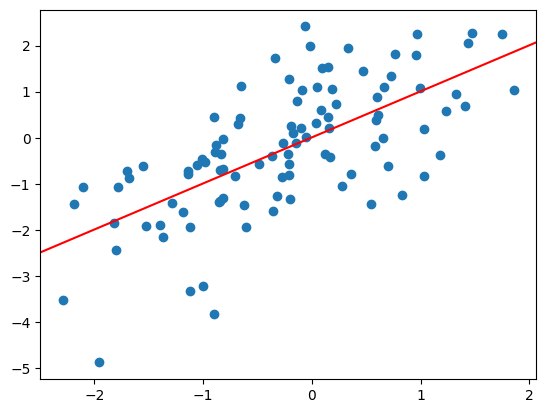

In [30]:
plt.scatter(X[:,0], y)
plt.axline((0, b[1]), slope=b[0], color="red")
plt.show()